# Squared Exponential kernel Gaussian process - PriorVAE


This is a demo notebook to showcase the usage of PriorVAE model on a Gaussian process dataset which is generated using a SquaredExponential kernel.

In [1]:
import random as rnd

import numpy as np 
import matplotlib.pyplot as plt
import numpyro
from numpyro.infer import Predictive
from numpyro.diagnostics import hpdi
numpyro.set_host_device_count(4)
import jax
import optax
from jax import random
import jax.numpy as jnp

from priorCVAE.models import MLPEncoder, MLPDecoder, VAE
from priorCVAE.priors import GP, SquaredExponential
from priorCVAE.mcmc import run_mcmc_vae, vae_mcmc_inference_model
from priorCVAE.datasets import GPDataset
from priorCVAE.trainer import VAETrainer

import jax.config as config
config.update("jax_enable_x64", True)

### Configuration

In [2]:
args = {
        # architecture
        "input_dim" : 50,
        "hidden_dim": 40,
        "latent_dim": 30,
        
        # VAE training    
        "batch_size": 500,
        "num_iterations": 4000,
        "learning_rate": 1e-3,

        # MCMC inference
        "true_ls": 0.2,
        "num_warmup": 1000,
        "num_samples": 4000,
        "num_chains": 4,
        "thinning": 1,
       }

### Generate data

We generate the data using an SquaredExponential kernel with lengthscale that is uniformly sampled. We plot a sample from the GP and plot the trajectories and lengthscales.

In [3]:
kernel = SquaredExponential()

gp_set = GPDataset(n_data=args["input_dim"], kernel=kernel, sample_lengthscale=True) 

In [4]:
sample_x_train, sample_y_train, sample_ls_train = gp_set.simulatedata(n_samples=1000)
x_test, y_test, ls_test = gp_set.simulatedata(n_samples=1000)

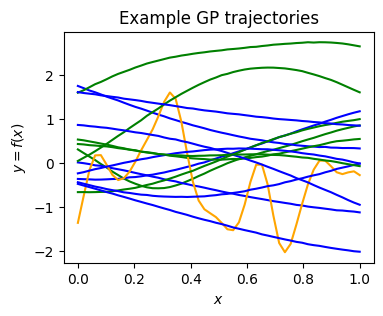

In [5]:
fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    if sample_ls_train[i] <= 0.2:
        col = 'orange'
    elif sample_ls_train[i] <= 0.6:
        col = 'green'
    else:
        col = 'blue'
    ax.plot(sample_x_train[i], sample_y_train[i], color=col)
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f(x)$')
ax.set_title('Example GP trajectories')

plt.show()

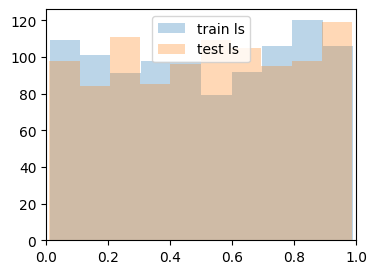

In [6]:
# Plot sample lengthscales
plt.figure(figsize=(4,3))
plt.hist(sample_ls_train[:, 0], alpha = 0.3, label = 'train ls') 
plt.hist(ls_test[:, 0],  alpha = 0.3, label = 'test ls') 
plt.xlim(0,1)
plt.legend()
plt.show()

### PriorVAE Model

We define the PriorVAE model, optimizer, and initialize the parameters of the model randomly.

In [7]:
out_dim     = args["input_dim"]
hidden_dim  = args["hidden_dim"]
latent_dim  = args["latent_dim"]
batch_size  = args["batch_size"]
num_samples = args["num_samples"]
num_iterations  = args["num_iterations"]
learning_rate = args["learning_rate"]

In [8]:
encoder = MLPEncoder(hidden_dim, latent_dim)
decoder = MLPDecoder(hidden_dim, out_dim)
model = VAE(encoder, decoder)

optimizer = optax.adam(learning_rate=learning_rate)

### Train the model

Train the model and plot the train loss and the test loss.

In [9]:
trainer = VAETrainer(model, optimizer)
trainer.init_params(sample_y_train[0])

test_set = (x_test, y_test, ls_test)
loss_vals, test_vals, time_taken = trainer.train(gp_set, test_set, num_iterations)

print(f'Training of {num_iterations} iterations took {round(time_taken)} seconds')


[    1] training loss: 5292.871, test loss: 56019.489
[   11] training loss: 3843.607, test loss: 38976.224
[   21] training loss: 3100.206, test loss: 34086.365
[   31] training loss: 3061.611, test loss: 31348.596
[   41] training loss: 2842.268, test loss: 28988.312
[   51] training loss: 2714.673, test loss: 26397.040
[   61] training loss: 2482.305, test loss: 23210.469
[   71] training loss: 1923.406, test loss: 20676.141
[   81] training loss: 1778.637, test loss: 19066.376
[   91] training loss: 1819.478, test loss: 18089.306
[  101] training loss: 1673.540, test loss: 17300.944
[  111] training loss: 1698.711, test loss: 16551.763
[  121] training loss: 1580.273, test loss: 16344.838
[  131] training loss: 1552.166, test loss: 15801.909
[  141] training loss: 1404.763, test loss: 15427.877
[  151] training loss: 1596.079, test loss: 14995.338
[  161] training loss: 1489.728, test loss: 14592.924
[  171] training loss: 1446.760, test loss: 14138.329
[  181] training loss: 1261.

[ 1561] training loss: 705.158, test loss: 7761.285
[ 1571] training loss: 706.472, test loss: 7690.468
[ 1581] training loss: 823.496, test loss: 7680.646
[ 1591] training loss: 727.499, test loss: 7622.602
[ 1601] training loss: 817.558, test loss: 7761.684
[ 1611] training loss: 654.547, test loss: 7660.389
[ 1621] training loss: 854.348, test loss: 7632.650
[ 1631] training loss: 784.299, test loss: 7670.988
[ 1641] training loss: 784.576, test loss: 7767.347
[ 1651] training loss: 717.075, test loss: 7549.662
[ 1661] training loss: 708.786, test loss: 7596.105
[ 1671] training loss: 642.820, test loss: 7699.292
[ 1681] training loss: 694.545, test loss: 7590.930
[ 1691] training loss: 695.972, test loss: 7634.994
[ 1701] training loss: 687.425, test loss: 7755.485
[ 1711] training loss: 560.841, test loss: 7670.943
[ 1721] training loss: 783.734, test loss: 7642.524
[ 1731] training loss: 787.854, test loss: 7686.032
[ 1741] training loss: 756.535, test loss: 7740.566
[ 1751] trai

[ 3141] training loss: 691.239, test loss: 7375.960
[ 3151] training loss: 709.651, test loss: 7303.822
[ 3161] training loss: 773.294, test loss: 7380.926
[ 3171] training loss: 792.030, test loss: 7331.963
[ 3181] training loss: 769.457, test loss: 7334.813
[ 3191] training loss: 695.416, test loss: 7295.660
[ 3201] training loss: 618.422, test loss: 7365.961
[ 3211] training loss: 664.867, test loss: 7311.069
[ 3221] training loss: 702.248, test loss: 7307.222
[ 3231] training loss: 742.780, test loss: 7336.872
[ 3241] training loss: 696.578, test loss: 7291.027
[ 3251] training loss: 716.197, test loss: 7305.373
[ 3261] training loss: 884.279, test loss: 7300.791
[ 3271] training loss: 733.107, test loss: 7310.908
[ 3281] training loss: 635.334, test loss: 7319.608
[ 3291] training loss: 678.988, test loss: 7243.132
[ 3301] training loss: 662.998, test loss: 7229.865
[ 3311] training loss: 696.930, test loss: 7287.559
[ 3321] training loss: 844.066, test loss: 7349.321
[ 3331] trai

Text(0.5, 1.0, 'Test loss')

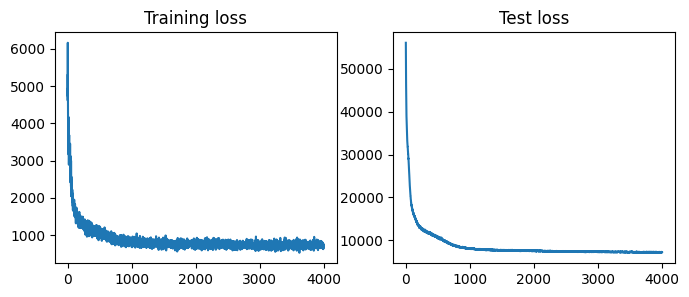

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(8, 3))

axs[0].plot(range(len(loss_vals)), loss_vals)
axs[0].set_title('Training loss')

axs[1].plot(range(len(test_vals)), test_vals)
axs[1].set_title("Test loss")


### Trained Decoder

We plot a sample of trajectories from the trained decoder model.

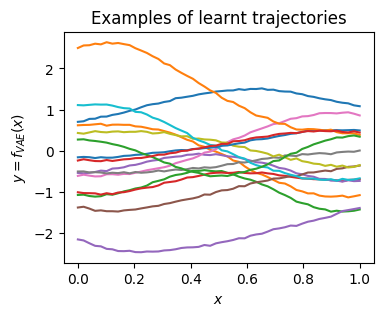

In [11]:
decoder_params = trainer.state.params['decoder']

key = jax.random.PRNGKey(rnd.randint(0, 9999))
rng, z_rng, init_rng = random.split(key, 3)
z = random.normal(z_rng, (batch_size, latent_dim))

decoder = MLPDecoder(hidden_dim, out_dim)
out = decoder.apply({'params': decoder_params}, z)             

fig, ax = plt.subplots(figsize=(4,3))
for i in range(15):
    ax.plot(sample_x_train[0], out[i,:])
ax.set_xlabel('$x$')
ax.set_ylabel('$y=f_{VAE}(x)$')
ax.set_title('Examples of learnt trajectories')

plt.show()

### Inference with MCMC

We randomly generate observations from the GP.

Text(0.5, 1.0, 'Ground truth, corresponds to $ls$=0.2')

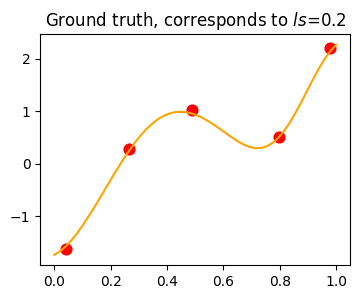

In [12]:
x = sample_x_train[0]

rng_key_draw =  random.PRNGKey(1)
rng_key, rng_key_post, rng_key_preds, rng_key_draw = random.split(rng_key_draw, 4)

kernel = SquaredExponential(lengthscale=args["true_ls"], variance=1.)
gp_predictive = Predictive(GP, num_samples=1)
draws = gp_predictive(rng_key_draw, kernel=kernel, x=x, jitter=1e-6, noise=True)

gp_draw = draws['f'].T
y_draw = draws['y'].T

# choose indices of data points for inference
obs_idx = jnp.array([2, 13, 24, 39, 48])
y_obs = y_draw[obs_idx,0]
x_obs = x[np.array(obs_idx)]

# add data to args. This is used by MCMC.
args["y_obs"] = y_obs
args["obs_idx"] = obs_idx

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

### Numpyro model

We define a Nupmyro model to run MCMC.

In [13]:
mcmc_vae, mcmc_vae_samples, t_elapsed = run_mcmc_vae(rng_key_post, vae_mcmc_inference_model, args, decoder, 
                                                     decoder_params)

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]

  0%|          | 0/5000 [00:00<?, ?it/s]


                mean       std    median      5.0%     95.0%     n_eff     r_hat
      f[0]     -0.79      0.30     -0.79     -1.30     -0.31  28331.79      1.00
      f[1]     -0.80      0.31     -0.80     -1.33     -0.31  28564.88      1.00
      f[2]     -0.79      0.32     -0.79     -1.32     -0.29  28665.17      1.00
      f[3]     -0.77      0.31     -0.77     -1.29     -0.27  28769.10      1.00
      f[4]     -0.76      0.31     -0.76     -1.29     -0.26  28598.80      1.00
      f[5]     -0.73      0.31     -0.73     -1.24     -0.23  28807.42      1.00
      f[6]     -0.68      0.30     -0.68     -1.16     -0.17  28811.78      1.00
      f[7]     -0.65      0.30     -0.65     -1.14     -0.16  29061.93      1.00
      f[8]     -0.60      0.28     -0.59     -1.05     -0.12  29166.30      1.00
      f[9]     -0.55      0.27     -0.55     -0.99     -0.09  29214.20      1.00
     f[10]     -0.47      0.27     -0.48     -0.90     -0.03  29096.47      1.00
     f[11]     -0.39      0

## Plotting

We plot the trajectory after MCMC.

Text(0.5, 1.0, 'PriorVAE inference')

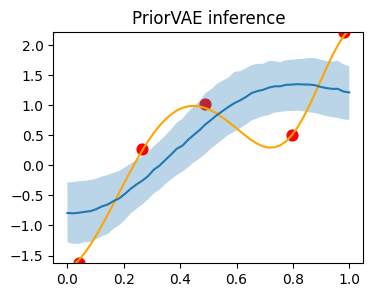

In [14]:
predictive = Predictive(vae_mcmc_inference_model, mcmc_vae_samples)
predictions_vae = predictive(rng_key_preds, args, decoder, decoder_params)["f"]

mean_post_pred_vae = jnp.mean(predictions_vae, axis=0)
hpdi_post_pred_vae = hpdi(predictions_vae, 0.9)
percentiles_vae = np.percentile(predictions_vae, [5.0, 95.0], axis=0)

N_lines = 10

plt.figure(figsize=(4,3))
plt.plot(x, gp_draw, label="ground truth", color="orange")
plt.scatter(x_obs, y_obs, color="red", label="observed data", s=60)
plt.title('Ground truth, corresponds to $ls$=' + str(args["true_ls"]))

plt.plot(x, mean_post_pred_vae, label="predicted mean VAE")
plt.fill_between(x, percentiles_vae[0, :], percentiles_vae[1, :], alpha=0.3, interpolate=True, 
                 label="VAE posterior: 90% BCI")

y_min = min(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[0, :]]))
y_max = max(np.concatenate([y_obs, mean_post_pred_vae, percentiles_vae[1, :]]))

plt.ylim([y_min, y_max])

plt.title('PriorVAE inference')